In [90]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [91]:
random.seed(42)

device = torch.device('cpu')
print("Device: ", device)

Device:  cpu


In [92]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [93]:
batch_size = 32
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [94]:
# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  print(len(loader.dataset))
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break
  print()

print_dim(train_loader,'training loader')
print_dim(val_loader,'validation loader')
print_dim(test_loader,'test loader')

---------training loader---------
40000
torch.Size([32, 3, 32, 32])
torch.Size([32])

---------validation loader---------
10000
torch.Size([32, 3, 32, 32])
torch.Size([32])

---------test loader---------
10000
torch.Size([32, 3, 32, 32])
torch.Size([32])



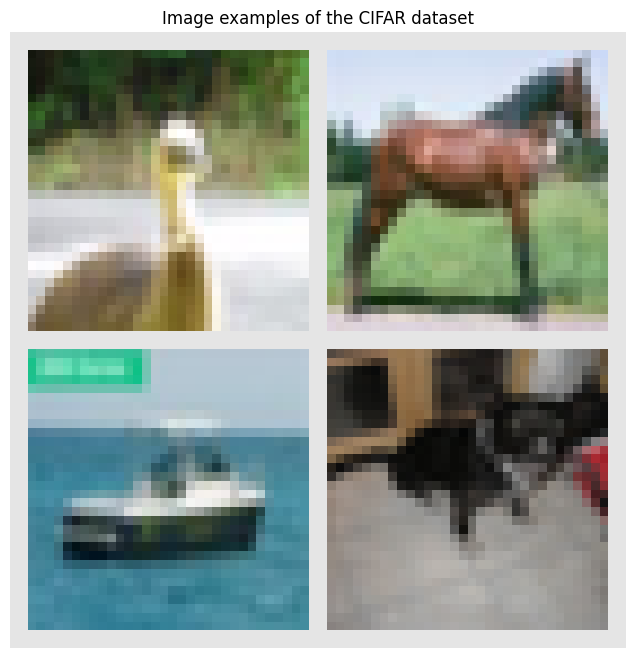

In [95]:
# Visualize some examples
NUM_IMAGES = 4
CIFAR_examples = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [96]:
image_size = 32
embed_dim=256
hidden_dim=embed_dim*3
num_heads=8
num_layers=8
patch_size=4
num_patches= (image_size/patch_size)**2
num_channels=3
num_classes=10
dropout=0.2

In [97]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], CIFAR [B, 3, 32, 32]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], CIFAR [B, 3, 4, 8, 4, 8]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], CIFAR [B, 4, 4, 3, 8, 8]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], CIFAR [B, 16, 3, 8, 8]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], CIFAR [B, 16, 192]
    return x

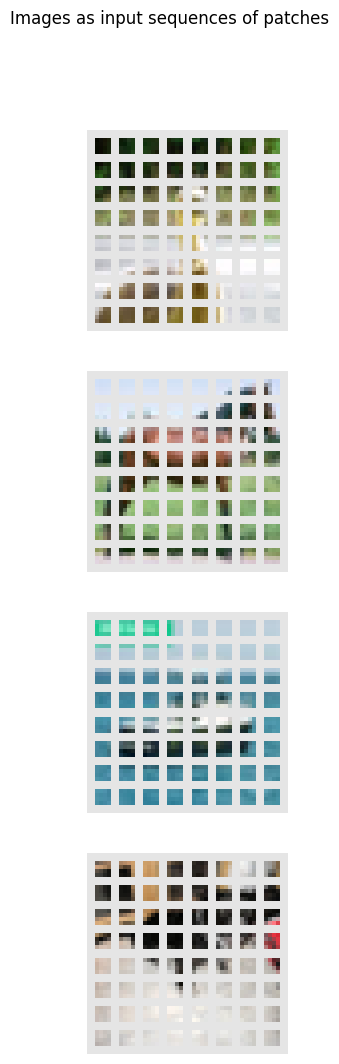

In [98]:
# Visualize the image patches
img_patches = img_to_patch(CIFAR_examples, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_examples.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(image_size/patch_size), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

In [99]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [100]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x) 

        cls_token = self.cls_token.repeat((B, 1, 1))
        x = torch.cat([x, cls_token], dim=1)
        x = x + self.pos_embedding[:, : T + 1] 

        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        cls = x[0]
        out = self.mlp_head(cls)

        return out


In [101]:
model = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          dropout=dropout)

model.to(device)

VisionTransformer(
  (input_layer): Linear(in_features=48, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=768, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Layer

In [102]:
loss_fn = torch.nn.CrossEntropyLoss()
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
model_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer)


# set an empty list to plot the loss later
lossi = []
# set an initial high value for the validation loss
best_vloss = 1_000_000
# set the timestamp to save the training model
timestamp = datetime.now().strftime('%Y%m%d_%H:%M:%S')
# Training loop
for epoch in range(20):
  print(f"starting epoch {epoch}")
  for (ind, (imgs, labels)) in enumerate(train_loader):
    if ind % 25 == 0:
      print(f"batch {ind}")
    model.train(True)
    imgs, labels = imgs.to(device), labels.to(device)
    model_optimizer.zero_grad()
    preds = model(imgs)
    loss = loss_fn(preds, labels)
    lossi.append(loss.item())
    loss.backward()
    model_optimizer.step()

  model_scheduler.step()
  running_vloss = 0.0
  model.eval()

  with torch.no_grad():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {:.4f} valid {:.4f}'.format(loss.item(), avg_vloss.item()))

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      path = './saved/model_VisionTransformer_CIFAR_{}.pt'.format(epoch+1)
      if not os.path.exists(path):
        open(path, "x")
      torch.save(model.state_dict(), path)

starting epoch 0
batch 0
batch 25
batch 50
batch 75
batch 100
batch 125
batch 150
batch 175
batch 200
batch 225
batch 250
batch 275
batch 300
batch 325
batch 350
batch 375
batch 400
batch 425
batch 450
batch 475
batch 500
batch 525
batch 550
batch 575
batch 600
batch 625
batch 650
batch 675
batch 700
batch 725
batch 750
batch 775
batch 800
batch 825
batch 850
batch 875
batch 900
batch 925
batch 950
batch 975
batch 1000


KeyboardInterrupt: 

Text(0.5, 1.0, 'Training loss')

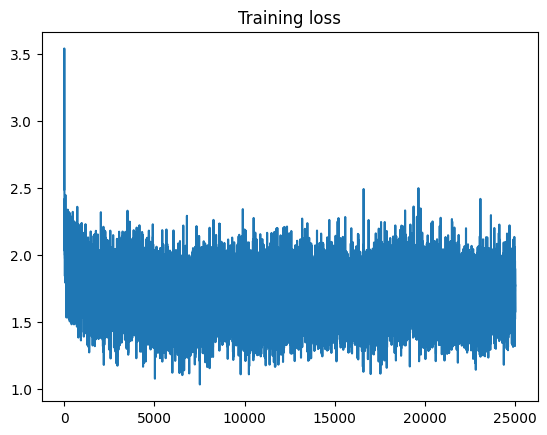

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(torch.tensor(lossi))
plt.title('Training loss')

In [ ]:
model_path = './model_VisionTransformer_CIFAR_6.pt'
model = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          dropout=dropout)

model.load_state_dict(torch.load(model_path))
model.to(device)

VisionTransformer(
  (input_layer): Linear(in_features=192, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=768, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Laye

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params

4007690

In [ ]:
# Set the model to evaluation mode, disabling dropout.
model.eval()
# evaluate network
acc_total = 0
with torch.no_grad():
  for imgs, labels in test_loader:

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc = acc_total.item()/len(test_loader.dataset)
print('Accuracy on test set = '+str(acc))


Accuracy on test set = 0.4228


In [ ]:
plt.imshow(test_set.data[0])

In [ ]:
for imgs, labels in test_loader:
    fig, ax = plt.subplots(nrows=8, ncols=4)
    for i in range(len(imgs)):
        fig.add_subplot(8, 4, i + 1)
        plt.imshow(torch.permute(imgs[i], (1, 2, 0)))
    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    print(pred_cls)
    acc_total += pred_cls.eq(labels.data).cpu().sum()
    break